# TP3: Classification de modulation par deep learning

Listez les noms des étudiants (3 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom, affectation).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp3.ipynb 

Installez les paquets nécessaires à la réalisation de ce TP
<br> 
Vous pouvez utiliser dans le notebook 
!pip install \<nom_du_paquet\>

## Imports


In [35]:
from matplotlib import pylab as plt 
import h5py 
import numpy as np 
import pandas as pd
from collections import Counter
from keras.utils import to_categorical
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torchmetrics import Accuracy
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Données



L'objectif de ce projet est à partir de l'observation de 1024 échantillons d'un signal IQ de retrouver la modulation qui l'a constitué parmi: 
- BPSK
- PSK8
- QAM16
- QAM32
- QAM64
- QAM8
- QPSK

A chaque modulation nous avons associé un nombre entier identifiant:
{'BPSK': 0,
 'PSK8': 1,
 'QAM16': 2,
 'QAM32': 3,
 'QAM64': 4,
 'QAM8': 5,
 'QPSK': 6}

FORMAT


Les données sont distribuées dans trois fichiers indépendants: 
- augmod_train.hdf5
- augmod_valid.hdf5
- augmod_test.hdf5 

L'ensemble de train est destiné à nourrir l'entraînement d'un réseau de neurones profond, l'ensemble de validation à monitorer l'évolution de métriques sur un ensemble indépendant durant un entraînement et l'ensemble de test est destiné à évaluer le modèle une fois entraîné. 

Les trois jeux de données sont au format hdf5 qui peut être manipulé via l'API Python h5py https://docs.h5py.org/en/stable/quick.html.
Un fichier hdf5 est consitué d'une arborescence de datasets et de groups. Un dataset hdf5 représente un tenseur n dimensionnel. Un dataset se convertit très facilement en numpy array.
Un groupe peut contenir plusieurs datasets. Un groupe contient aussi un champs .attrs qui permet de regrouper des informations sous forme de dictionnaire. 

Un fichier de données D contient: 
- un groupe 'labels' qui regroupe les correspondances nom_modulation -> id_modulation 
   - D['labels'].attrs[k] avec k dans D['labels'].attrs.keys() 
   - plus bas la fonction get_labels permet d'extraire ces correspondances sous forme d'un dictionnaire
- un dataset 'signal': D['signal'] qui est de dimensions [N,2,1024] et contient N signaux IQ de 1024 échantillons
- un dataset 'snr': D['snr'] qui est de dimension [N], la composante  i codant le rapport signal sur bruit (en dB) du signal D['signal'][i,:,:] 

Les cellules suivantes donne un exemple d'ouverture d'un des fichiers de données: 

### Fonction utilitaire

In [37]:
def get_labels(open_h5_file): 
    return {
        open_h5_file['labels'].attrs[k] : k
        for k in open_h5_file['labels'].attrs.keys()
    }

### Conversion directe en numpy

In [38]:
data_path = '/content/drive/MyDrive/MVA/Traitement de signal/TP/TP3/augmod_train.hdf5'

data = h5py.File(data_path , 'r')

signals = np.array(data['signals'])
snr =  np.array(data['snr'])
labels_id = np.array(data['type'])

labels_dict = get_labels(data)

data.close()

Il y a 87360 signaux, de dimensions (2,)



Le SNR du signal 1001 est 40.0
Le signal 1001 a pour id 1 il est de type PSK8


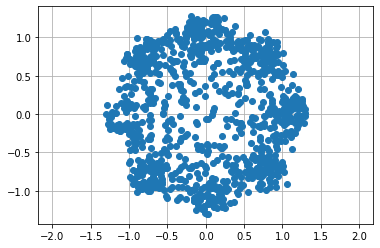

In [39]:
print(f'Il y a {signals.shape[0]} signaux, de dimensions {signals.shape[1:2]}')
print('\n\n')

num_signal = 1001 

plt.figure()
print(f'Le SNR du signal {num_signal} est {snr[num_signal]}' )
print(f'Le signal {num_signal} a pour id {labels_id[num_signal]} il est de type {labels_dict[labels_id[num_signal]]}' )

plt.plot(signals[num_signal,0,:] , signals[num_signal,1,:],'o')
plt.axis('equal')
plt.grid()

### Utilisation des buffers hdf5 

# Objectifs du TP 



Pour ce TP vous devez 

1/ Visualiser les données d'entraînement, la distribution des types de modulations représentées dans l'ensemble de données et la distribution des SNR
2/ (optionnel) Proposer une méthode simple, 'baseline' pour l'identification de modulations
3/ Définir une ou plusieurs architectures de réseaux de neurones profonds et les implémenter en PyTorch
4/ Entrainer ces architectures, la fonction de perte employée pourra être la log vraisemblance négative: https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html. 
5/ Qualifier les performances de votre réseau de neurones sur l'ensemble de test via: 
   - Le calcul de l'accuracy implémentée par exemple dans le package TorchMetrics (https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html)
   - La réalisation d'un graphique accuracy vs SNR 
   - La réalisation des matrices de confusion entre les différentes classes pour un SNR de 10 dB (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)

Durant l'entraînement on observera l'évolution de la fonction de perte et de l'accuracy sur l'ensemble d'entraînement et sur l'ensemble de validation. 

## Visualisation 

Dans cette section on va visualiser differents types de signal et analyser les differences carracteristiques de ces derniers 

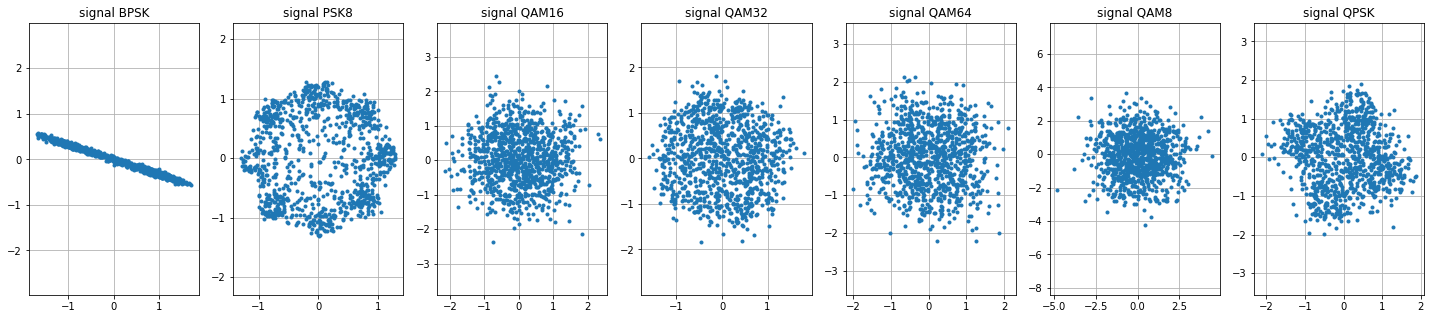

In [7]:
data = h5py.File(data_path , 'r')
classes_signals=range(7)

fig=plt.figure(figsize=(25,5))
for i in classes_signals:
        ax1 = fig.add_subplot(1,len(classes_signals),i+1)
        num_signal=1000
        aux=labels_id[num_signal]
        while aux!=i:
          num_signal+=1
          aux=labels_id[num_signal]
        ax1.plot(data['signals'][num_signal,0,:] , data['signals'][num_signal,1,:],'.')
        ax1.axis('equal')
        ax1.grid()
        ax1.set_title('signal ' + str(labels_dict[aux]))
plt.show()
data.close()

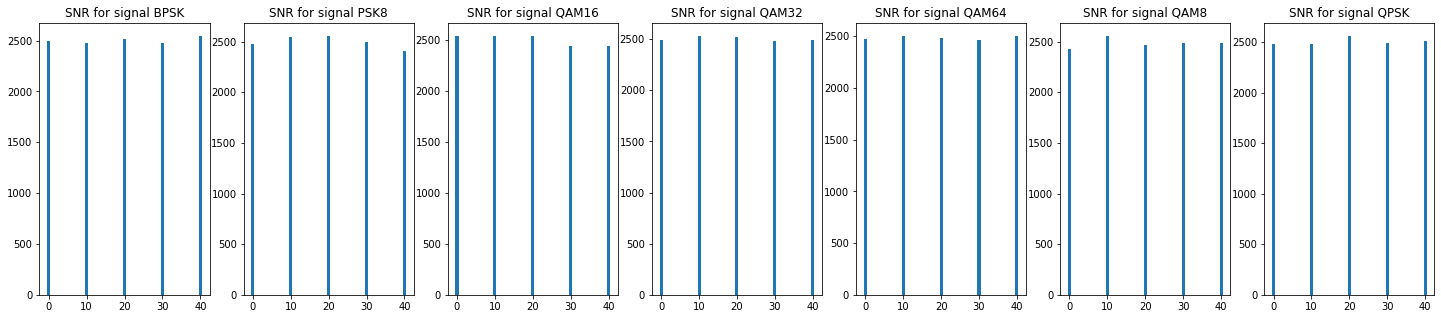

In [8]:
data = h5py.File(data_path , 'r')
classes_signals=range(7)

fig=plt.figure(figsize=(25,5))
for i in classes_signals:
  ax1 = fig.add_subplot(1,len(classes_signals),i+1)
  count_dic=Counter(data['snr'][np.where(labels_id==i)])
  ax1.bar(list(count_dic.keys()),list(count_dic.values()))
  ax1.set_title('SNR for signal ' + str(labels_dict[i]))

data.close()

Interpretation


> En ce qui concerne la distribution des signaux selon les categories on peut remarquer des patterns qui carracterise chaque type aisni en nourrissant un reseaux de neuronnes de ces distributions on peut prevoir des resultats assez significatifs. Pour les SNR (le rapport signal/bruit) on remarque une distribution uniforme sur les signaux ainsi que les rapports





# Classification 

## Initial setup

### DataFrames


For this part we're going to implement the detailed method from this [blog ](https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel)



```
# Partitions

```



In [9]:
#fix the training data frame 
data_path = '/content/drive/MyDrive/MVA/Traitement de signal/TP/TP3/augmod_train.hdf5'
data = h5py.File(data_path , 'r')

signals_train = np.array(data['signals'])
snr_train =  np.array(data['snr'])
labels_id_train= np.array(data['type'])

data.close()
print(labels_id_train.shape)

#fix the validation data 
#reminder
data_path = '/content/drive/MyDrive/MVA/Traitement de signal/TP/TP3/augmod_valid.hdf5'
data = h5py.File(data_path , 'r')

signals_valid = np.array(data['signals'])
snr_valid =  np.array(data['snr'])
labels_id_valid= np.array(data['type'])

data.close()
print(signals_valid.shape)

(87360,)
(43680, 2, 1024)


In [10]:
# Partition 
train_id=[''.join(['id-',str(i)]) for i in range(1, len(labels_id_train)+1)]
valid_id=[''.join(['id-',str(i+len(labels_id_train))]) for i in range(1, len(labels_id_valid)+1)]

partition={'train': train_id, 'valid': valid_id}
#labels
Full_labels=list(labels_id_train)+ list(labels_id_valid)
Full_ids=train_id+ valid_id

labels={Full_ids[i]:Full_labels[i] for i in range(len(Full_labels))}

#signals
full_signal=np.concatenate((signals_train,signals_valid),axis=0)



```
# Dataset and dataloader
```



In [11]:
#dataset
import torch

class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, list_IDs, labels,list_signals):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs
        self.signals = list_signals

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        X = self.signals[index,:,:]
        y = self.labels[ID]

        return X, float(y)

#dataloader 
from torch.utils.data import DataLoader
train_dataset=Dataset(partition['train'],labels, full_signal)
train_generator=DataLoader(
    Dataset(partition['train'],labels, full_signal),
    batch_size=64,
    shuffle=True,
    num_workers=10,
 )
valid_dataset=Dataset(partition['valid'],labels,full_signal)
valid_generator=DataLoader(
    Dataset(partition['valid'],labels,full_signal),
    batch_size=64,
    shuffle=True,
    num_workers=10,
 )

### Baseline model 



```
# Simple Neural network 
```



In [12]:
#simple model
import torch.nn as nn
class Net(nn.Module):
    def __init__(self,input,H,output):
        super(Net,self).__init__()
        self.conv1=nn.Conv1d(input,2,1)
        self.linear1=nn.Linear(H*2,output)
 
        
    def forward(self,x):
        x=x.to( dtype = torch.float32) 
        x=torch.tanh(self.conv1(x))  
        x=torch.flatten(x, start_dim=1) 
        x=self.linear1(x)
        return x.to( dtype = torch.float32) 

In [13]:
#Instantiating the classifier
input_dim =2
hidden_dim=1024
output_dim=7  #num classes

clf=Net(input_dim,hidden_dim,output_dim)
print(clf.parameters)

<bound method Module.parameters of Net(
  (conv1): Conv1d(2, 2, kernel_size=(1,), stride=(1,))
  (linear1): Linear(in_features=2048, out_features=7, bias=True)
)>




```
# Train and test
```



In [14]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

#training parameters
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(clf.parameters(), lr=0.1)
max_epochs = 10
learning_rate = 1e-1

In [15]:
#test and train functions
def train(epoch, network):
    batch_idx=0
    network.train()
    for local_batch, local_labels in train_generator:
        batch_idx+=1
        optimizer.zero_grad()
        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.long().to(device)
        # Model computations
        output=network(local_batch).to(device)
        loss = criterion(output, local_labels)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(local_labels), len(train_generator.dataset),
                100. * batch_idx / len(train_generator), loss.item()))

def test(network):
    network.eval()
    test_loss = 0
    correct = 0
    for local_batch, local_labels in valid_generator:
      # Transfer to GPU
      local_batch, local_labels = local_batch.to(device), local_labels.long().to(device)
      # Model computations
      output=network(local_batch).to(device)
      loss = criterion(output, local_labels)
      test_loss += loss.item() # sum up batch loss
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(local_labels.data.view_as(pred)).cpu().sum()

    test_loss /= len(valid_generator.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(valid_generator.dataset),
        100. * correct / len(valid_generator.dataset)))

## Draft

### Dataloader

In [40]:
# Load data and convert to numpy
def load_data(data_path):
  # load file
  data = h5py.File(data_path , 'r')

  signals = np.array(data['signals'])
  snr =  np.array(data['snr'])
  labels_id = np.array(data['type'])

  data.close()

  return signals, snr, labels_id

folder_path = '/content/drive/MyDrive/MVA/Traitement de signal/TP/TP3/augmod_'

signals_train, snr_train, labels_id_train = load_data(folder_path+"train.hdf5")
signals_val, snr_val, labels_id_val = load_data(folder_path+"valid.hdf5")
signals_test, snr_test, labels_id_test = load_data(folder_path+"test.hdf5")

# load labels dict
data = h5py.File(folder_path+"train.hdf5" , 'r')
abels_dict = get_labels(data)
data.close()

In [41]:
# dataloader
batch_size = 64
dataloader_train = torch.utils.data.DataLoader(
    list(zip(np.arange(len(signals_train)), signals_train, labels_id_train)), 
                                               batch_size = batch_size,
                                               shuffle = True)
dataloader_val = torch.utils.data.DataLoader(
    list(zip(np.arange(len(signals_val)), signals_val, labels_id_val)), 
                                               batch_size = 256)
dataloader_test = torch.utils.data.DataLoader(
    list(zip(np.arange(len(signals_test)), signals_test, labels_id_test)), 
                                               batch_size = 256)

### Training class

In [208]:
class Trainer:
  def __init__(self, model, criterion, optimizer, device):
    # set model
    self.model = model
    # set optim
    self.criterion = criterion
    self.optimizer = optimizer

    self.device = device
  def train(self, dataloader_train, dataloader_val, n_epochs,
            augment = False):
    
    self.losses_train = []
    self.losses_val = []
    for i_epoch in range(n_epochs):
      
      for i_batch, (ids, signals, labels) in enumerate(tqdm(dataloader_train)):
        self.model.train()
        # data to gpu
        signals = signals.float().to(self.device)
        labels = labels.long().to(self.device)
        # online augmentation
        if augment :
          n = np.random.randint(0,len(signals)//2)
          for j in range(n):
            indx_signal = np.random.randint(0, len(signals))
            # symbol permutation in sequence
            indx_perm = np.random.permutation(signals.shape[-1])
            signals[j] = signals[j,:, indx_perm]

        # zero grads
        self.optimizer.zero_grad()

        # forward 
        scores = self.model(signals)
        
        loss = self.criterion(scores, labels)
        loss.backward()
        # clip grad
        #nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        self.optimizer.step( )
      
      scheduler.step()

      # metrics
      scores_train, labels_train, loss_train, _ = self.predict(dataloader_train)
      preds_train = torch.argmax(scores_train, dim = 1)
      acc_train = accuracy(preds_train, labels_train)
      self.losses_train.append(loss_train)

      scores_val, labels_val, loss_val, _ = self.predict(dataloader_val)
      preds_val = torch.argmax(scores_val, dim = 1)
      acc_val = accuracy(preds_val, labels_val)
      self.losses_val.append(loss_val)

      print(f"EPOCH {i_epoch + 1:3d}| TRAIN - loss:{loss_train:10.3f}"
            f" - acc_train:{acc_train*100:5.3f}"
            f" - acc_val:{acc_val*100:5.3f}")

  def predict(self, dataloader):
    scores = []
    labels = []
    ids = []
    loss = 0
    for ids_batch, signals_batch, labels_batch in dataloader:
      self.model.eval()
      
      # data to gpu
      signals_batch = signals_batch.float().to(device)
      labels_batch = labels_batch.long().to(device)   

      # forward 
      with torch.no_grad():
        scores_batch = model(signals_batch)
      # loss
      loss += criterion(scores_batch, labels_batch).item()

      labels.append(labels_batch.cpu())
      scores.append(scores_batch.cpu())
      ids.append(ids_batch)

    return torch.cat(scores), torch.cat(labels), loss/len(dataloader), torch.cat(ids)

### Models

In [43]:
class CNN_1(nn.Module):
  def __init__(self, in_channels, n_classes, input_len):
    super().__init__()
    n_channels_1 = 64
    n_channels_2 = 32
    n_channels_3 = 16

    self.block1 = nn.Sequential(
        nn.Conv1d(in_channels = in_channels, out_channels = n_channels_1,
                                kernel_size = 7, padding = "same", groups = 1),
        nn.BatchNorm1d(n_channels_1),
        nn.ReLU(inplace = True),

        nn.Conv1d(in_channels = n_channels_1, out_channels = n_channels_1,
                                kernel_size = 7, padding = "same", groups = 1),
        nn.BatchNorm1d(n_channels_1),
        nn.ReLU(inplace = True),
    )
    self.residual1 = nn.Conv1d(in_channels = in_channels, out_channels = 1, 
                              kernel_size = 1)

    self.maxpool1 = nn.MaxPool1d(kernel_size = 2, stride = 2)

    self.block2 = nn.Sequential(
        nn.Conv1d(in_channels = n_channels_1, out_channels = n_channels_2,
                                kernel_size = 5, padding = "same", groups = 1),
        nn.BatchNorm1d(n_channels_2),
        nn.ReLU(inplace = True),

        nn.Conv1d(in_channels = n_channels_2, out_channels = n_channels_2,
                                kernel_size = 5, padding = "same", groups = 1),
        nn.BatchNorm1d(n_channels_2),
        nn.ReLU(inplace = True),
    )
    self.residual2 = nn.Sequential(
        nn.Conv1d(in_channels = n_channels_1, out_channels = 1, 
                              kernel_size = 1),
    )
    self.maxpool2 = nn.MaxPool1d(kernel_size = 4, stride = 4)

    self.block3 = nn.Sequential(
        nn.Conv1d(in_channels = n_channels_2, out_channels = n_channels_3,
                                kernel_size = 3, padding = "same", groups = 1),
        nn.BatchNorm1d(n_channels_3),
        nn.ReLU(inplace = True),

        nn.Conv1d(in_channels = n_channels_3, out_channels = n_channels_3,
                                kernel_size = 3, padding = "same", groups = 1),
        nn.BatchNorm1d(n_channels_3),
        nn.ReLU(inplace = True),
    )
    self.residual3 = nn.Sequential(
        nn.Conv1d(in_channels = n_channels_2, out_channels = 1, 
                              kernel_size = 1),
    )
    self.maxpool3 = nn.MaxPool1d(kernel_size = 4, stride = 4)


    self.avgpool = nn.Conv1d(in_channels = n_channels_3, out_channels = n_channels_3 *2,
                                kernel_size = input_len//(2**5), 
                                groups = n_channels_3)

    # Linear
    self.linear = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = n_channels_3 *2, 
                  out_features = n_classes),
          
        nn.LogSoftmax(dim = 1)
    )

  def forward(self, s):

    f1 = self.block1(s)
    res1 = self.residual1(s)
    f1 = self.maxpool1(F.relu(f1+res1))

    f2 = self.block2(f1)
    res2 = self.residual2(f1)
    f2 = self.maxpool2(F.relu(f2+res2))

    f3 = self.block3(f2)
    res3 = self.residual3(f2)
    f3 = self.maxpool3(F.relu(f3+res3))    
    
    f5 = self.avgpool(f3)

    o = self.linear(f5)
    return o

### Training and evaluation model CNN_1

In [44]:
# instantiate model
in_channels = signals_train.shape[1]
n_classes = len(labels_dict)
model = CNN_1(in_channels = in_channels, n_classes = n_classes, 
              input_len = signals_train.shape[-1])
model = model.to(device)

# hyperparam
lr = 5e-4
# prep optimization
optimizer = torch.optim.Adam(params = model.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, 
                                      milestones=[10, 15, 20, 30], gamma=0.6,
                                      verbose = True)
criterion = nn.NLLLoss().to(device)
# prepr metrics
accuracy = Accuracy(task='multiclass',num_classes = len(labels_dict))

Adjusting learning rate of group 0 to 5.0000e-04.


### Transformer model

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, fc_hidden_size, output_size, bidirectional, num_layers=1, dropout=0.0):
        super(GRU, self).__init__()
        self.gru = nn.GRU(
                          input_size=input_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True,
                          bidirectional=bidirectional, 
                          dropout=dropout
                          )
                          
        self.fc1 = nn.Linear(hidden_size, fc_hidden_size) 
        self.fc2 = nn.Linear(fc_hidden_size, output_size) 

    
    # x: (batch_size, seq_len, input_size) 
    def forward(self, x):
        r_out, h_n = self.gru(x, None) # r_out: (batch_size, seq_len, hidden_size)

        last_time_step_out = r_out[:, -1,:] 
        last_layer_output = self.fc2(F.relu(self.fc1(last_time_step_out)))
        
        return  nn.functional.log_softmax(last_layer_output, dim=1)

In [97]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, fc_hidden_size, output_size, bidirectional, num_layers=1, dropout=0.0):
        super(LSTM, self).__init__()
        self.rnn = nn.LSTM(
                          input_size=input_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True,
                          bidirectional=bidirectional,
                          dropout=dropout
                          )
                           
        self.fc1 = nn.Linear(hidden_size, fc_hidden_size) 
        self.fc2 = nn.Linear(fc_hidden_size, output_size) 

    
    # x: (batch_size, seq_len, input_size) 
    def forward(self, x):
        r_out, h_n = self.rnn(x, None)  # r_out: (batch_size, seq_len, hidden_size)
         
        last_time_step_out = r_out[:, -1,:] 
        last_layer_output = self.fc2(F.relu(self.fc1(last_time_step_out)))

        return nn.functional.log_softmax(last_layer_output, dim=1)

In [135]:
class FNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, non_linear='tanh', dropout=0.0):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        self.bn1 = nn.BatchNorm1d(hidden_size[0])

        self.num_hidden = len(hidden_size)
        self.non_linear = nn.ReLU()
        self.hidden = nn.ModuleList()
        self.bn = nn.ModuleList()
        self.dropout = nn.Dropout(dropout)

        for i in range(self.num_hidden - 1):
            self.hidden.append(nn.Linear(hidden_size[i], hidden_size[i+1]))
            self.bn.append(nn.BatchNorm1d(hidden_size[i+1]))
        self.fc2 = nn.Linear(hidden_size[self.num_hidden - 1], output_size)
    
    def forward(self, x):
        global device
        var_x = x.to(device=device)
        logitis = self.dropout(self.non_linear(self.bn1(self.fc1(var_x))))
        for i in range(self.num_hidden - 1):
            logitis = self.dropout(self.non_linear(self.bn[i](self.hidden[i](logitis))))
        compressed_signal = logitis
        logitis = self.fc2(logitis)
        return nn.functional.log_softmax(logitis[:, -1,:] , dim=1)



In [142]:
import torch
import torch.nn as nn
from torch.autograd import Variable


class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size):
        super(ConvLSTMCell, self).__init__()

        assert hidden_channels % 2 == 0

        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.num_features = 4

        self.padding = int((kernel_size - 1) / 2)

        self.Wxi = nn.Conv1d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Whi = nn.Conv1d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)
        self.Wxf = nn.Conv1d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Whf = nn.Conv1d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)
        self.Wxc = nn.Conv1d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Whc = nn.Conv1d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)
        self.Wxo = nn.Conv1d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Who = nn.Conv1d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)

        self.Wci = None
        self.Wcf = None
        self.Wco = None

    def forward(self, x, h, c):
        ci = torch.sigmoid(self.Wxi(x) + self.Whi(h) + c * self.Wci)
        cf = torch.sigmoid(self.Wxf(x) + self.Whf(h) + c * self.Wcf)
        cc = cf * c + ci * torch.tanh(self.Wxc(x) + self.Whc(h))
        co = torch.sigmoid(self.Wxo(x) + self.Who(h) + cc * self.Wco)
        ch = co * torch.tanh(cc)
        return ch, cc

    def init_hidden(self, batch_size, hidden, shape):
        if self.Wci is None:
            self.Wci = nn.Parameter(torch.zeros(1, hidden, shape[0], shape[1])).cuda()
            self.Wcf = nn.Parameter(torch.zeros(1, hidden, shape[0], shape[1])).cuda()
            self.Wco = nn.Parameter(torch.zeros(1, hidden, shape[0], shape[1])).cuda()
        else:
            assert shape[0] == self.Wci.size()[2], 'Input Height Mismatched!'
            assert shape[1] == self.Wci.size()[3], 'Input Width Mismatched!'
        return (Variable(torch.zeros(batch_size, hidden, shape[0], shape[1])).cuda(),
                Variable(torch.zeros(batch_size, hidden, shape[0], shape[1])).cuda())


class ConvLSTM(nn.Module):
    # input_channels corresponds to the first input feature map
    # hidden state is a list of succeeding lstm layers.
    def __init__(self, input_channels, hidden_channels, kernel_size, step=1, effective_step=[1]):
        super(ConvLSTM, self).__init__()
        self.input_channels = [input_channels] + hidden_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.num_layers = len(hidden_channels)
        self.step = step
        self.effective_step = effective_step
        self._all_layers = []
        for i in range(self.num_layers):
            name = 'cell{}'.format(i)
            cell = ConvLSTMCell(self.input_channels[i], self.hidden_channels[i], self.kernel_size)
            setattr(self, name, cell)
            self._all_layers.append(cell)

    def forward(self, input):
        internal_state = []
        outputs = []
        for step in range(self.step):
            x = input
            for i in range(self.num_layers):
                # all cells are initialized in the first step
                name = 'cell{}'.format(i)
                if step == 0:
                    bsize, height, width = x.size()
                    (h, c) = getattr(self, name).init_hidden(batch_size=bsize, hidden=self.hidden_channels[i],
                                                             shape=(64, 7))
                    internal_state.append((h, c))

                # do forward
                (h, c) = internal_state[i]
                x, new_c = getattr(self, name)(x, h, c)
                internal_state[i] = (x, new_c)
            # only record effective steps
            if step in self.effective_step:
                outputs.append(x)

        return outputs, (x, new_c)


In [212]:

import math
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm1d(in_planes)
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv1d(in_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        return torch.cat([x, out], 1)

class BottleneckBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(BottleneckBlock, self).__init__()
        inter_planes = out_planes * 4
        self.bn1 = nn.BatchNorm1d(in_planes)
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv1d(in_planes, inter_planes, kernel_size=1, stride=1,
                               padding=0, bias=False)
        self.bn2 = nn.BatchNorm1d(inter_planes)
        self.conv2 = nn.Conv1d(inter_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        out = self.conv2(self.relu(self.bn2(out)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        return torch.cat([x, out], 1)

class TransitionBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(TransitionBlock, self).__init__()
        self.bn1 = nn.BatchNorm1d(in_planes)
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv1d(in_planes, out_planes, kernel_size=1, stride=1,
                               padding=0, bias=False)
        self.droprate = dropRate
    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        return F.avg_pool1d(out, 2)

class DenseBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, growth_rate, block, dropRate=0.0):
        super(DenseBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, growth_rate, nb_layers, dropRate)
    def _make_layer(self, block, in_planes, growth_rate, nb_layers, dropRate):
        layers = []
        for i in range(nb_layers):
            layers.append(block(in_planes+i*growth_rate, growth_rate, dropRate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)

class DenseNet3(nn.Module):
    def __init__(self, depth, num_classes, growth_rate=12,
                 reduction=0.5, bottleneck=True, dropRate=0.0):
        super(DenseNet3, self).__init__()
        in_planes = 2 * growth_rate
        n = (depth - 4) / 3
        if bottleneck == True:
            n = n/2
            block = BottleneckBlock
        else:
            block = BasicBlock
        n = int(n)
        # 1st conv before any dense block
        self.conv1 = nn.Conv1d(2, in_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+n*growth_rate)
        self.trans1 = TransitionBlock(in_planes, int(math.floor(in_planes*reduction)), dropRate=dropRate)
        in_planes = int(math.floor(in_planes*reduction))
        # 2nd block
        self.block2 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+n*growth_rate)
        self.trans2 = TransitionBlock(in_planes, int(math.floor(in_planes*reduction)), dropRate=dropRate)
        in_planes = int(math.floor(in_planes*reduction))
        # 3rd block
        self.block3 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+n*growth_rate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm1d(in_planes)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(in_planes, num_classes)
        self.in_planes = in_planes

        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                n = m.kernel_size[0] * m.kernel_size[0] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
    def forward(self, x):
        
        out = self.conv1(x)
        print('here')
        out=self.block1(out)

        out = self.trans1(out)
        out = self.trans2(self.block2(out))
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool1d(out, 8)
        print(out.shape)
        out = out.view(-1, self.in_planes)
        print(out.shape)
        return nn.functional.log_softmax(self.fc(out),dim=1)

In [213]:
# instantiate model
in_channels = signals_train.shape[1]
n_classes = len(labels_dict)
model = DenseNet3( 16,n_classes)
model = model.to(device)

# hyperparam
lr = 5e-4
# prep optimization
optimizer = torch.optim.Adam(params = model.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, 
                                      milestones=[10, 15, 20, 30], gamma=0.6,
                                      verbose = True)
criterion = nn.NLLLoss().to(device)
# prepr metrics
accuracy = Accuracy(task='multiclass',num_classes = len(labels_dict))

Adjusting learning rate of group 0 to 5.0000e-04.


In [214]:
trainer = Trainer(model, criterion, optimizer, device)
trainer.train(dataloader_train, dataloader_val, 100, augment = False)

  0%|          | 0/1365 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-04.
EPOCH   1| TRAIN - loss:  -339.599 - acc_train:14.304 - acc_val:14.190


  0%|          | 0/1365 [00:00<?, ?it/s]

KeyboardInterrupt: ignored